In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('intershipproject_modified.csv')

In [2]:
df.head(5)

,eventId,eventName,eventTime,numberPlate,ownerName,speedLimit,speedDetected,ownerAge,location,vehicleRegistrationYear,ageOfVehicle,brandOfCar,maritalStatus
0,81999,Over Speed,16-06-2023 10.24,PB 26 WC 9915,Aaina,100,114,36,Rural,2010,14,Tata,Married
1,86613,No Helmet,23-08-2023 4.55,PB 26 WC 9915,Aaina,120,58,36,Rural,2010,14,Tata,Married
2,86085,Hit and Run,15-09-2023 13.44,PB 26 WC 9915,Aaina,100,71,36,Rural,2010,14,Tata,Married
3,69485,Driving Under the Influence (DUI),29-04-2023 13.55,AR 22 OF 9491,Aarna,100,43,50,Rural,2021,3,Tata,Single
4,13622,No Helmet,11-06-2023 20.17,AR 22 OF 9491,Aarna,100,82,50,Rural,2021,3,Tata,Single


In [3]:

severity_points = {
    'Wrong Way Detection': 700,
    'Red Light Violation Detection': 500,
    'Hit and Run': 1000,
    'Wrong Licence Plate': 300,
    'Reckless Driving': 800,
    'Driving Under the Influence (DUI)': 900,
    'Triple Ride': 600,
    'Not Wearing Seat Belts': 200,
    'Over Speed': 400,
    'No Helmet': 250,
    'Vehicle Crossing Zebra Line': 350,
    'Vehicle Moving in Marked Area': 450
}
df['severityPoints'] = df['eventName'].map(severity_points)

df['totalViolations'] = df.groupby(['ownerName', 'numberPlate'])['eventId'].transform('count')

def classify_violation_level(points):
    if points >= 800:
        return 'high'
    elif points >= 300:
        return 'medium'
    else:
        return 'low'

df['violationLevel'] = df['severityPoints'].apply(classify_violation_level)

owner_severity = df.groupby('numberPlate')['severityPoints'].sum()
max_severity = owner_severity.max()
df['riskScore'] = df['numberPlate'].map(lambda x: int((owner_severity[x] / max_severity) * 100))

In [4]:
df[['eventName', 'severityPoints', 'totalViolations', 'violationLevel']]

,eventName,severityPoints,totalViolations,violationLevel
0,Over Speed,400,3,medium
1,No Helmet,250,3,low
2,Hit and Run,1000,3,high
3,Driving Under the Influence (DUI),900,2,high
4,No Helmet,250,2,low
...,...,...,...,...
995,Hit and Run,1000,5,high
996,Vehicle Moving in Marked Area,450,5,medium
997,Wrong Way Detection,700,5,medium
998,Triple Ride,600,2,medium


In [5]:
location_mapping = {'Urban': 0, 'Rural': 1}
marital_status_mapping = {'Married': 0, 'Single': 1}
brand_mapping = {'Mahindra': 0, 'Hyundai': 1, 'Tata': 2, 'Maruti': 3}

df['location'] = df['location'].map(location_mapping)
df['maritalStatus'] = df['maritalStatus'].map(marital_status_mapping)
df['brandOfCar'] = df['brandOfCar'].map(brand_mapping)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import numpy as np


features = ['severityPoints', 'totalViolations', 'ownerAge', 'ageOfVehicle', 'speedDetected', 'location', 'brandOfCar']
X = df[features]
y = df['riskScore']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}


results = {}

for name, model in models.items():
   
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
   
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Cross-Validation MAE': -scores.mean(),
        'Test MAE': mae,
        'Test MSE': mse,
        'Test RMSE': rmse,
        'Test R²': r2
    }


for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


RandomForestRegressor:
Cross-Validation MAE: 4.0034
Test MAE: 3.7213
Test MSE: 29.3416
Test RMSE: 5.4168
Test R²: 0.9101

LinearRegression:
Cross-Validation MAE: 6.6644
Test MAE: 7.0410
Test MSE: 73.6096
Test RMSE: 8.5796
Test R²: 0.7744

DecisionTreeRegressor:
Cross-Validation MAE: 4.3325
Test MAE: 3.8700
Test MSE: 51.9600
Test RMSE: 7.2083
Test R²: 0.8408

GradientBoostingRegressor:
Cross-Validation MAE: 5.6674
Test MAE: 6.0424
Test MSE: 56.1672
Test RMSE: 7.4945
Test R²: 0.8279

SVR:
Cross-Validation MAE: 16.3769
Test MAE: 13.6167
Test MSE: 309.3452
Test RMSE: 17.5882
Test R²: 0.0520


# model building

In [7]:
features = ['severityPoints', 'totalViolations','ownerAge', 'ageOfVehicle', 'speedDetected','location','brandOfCar']

X = df[features]
y = df['riskScore']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.7213


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 29.341566111111113


In [9]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9100779463343208


In [10]:
import numpy as np
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 5.416785588438139


In [11]:
df['predictedRiskScore'] = model.predict(X)

df['predictedRiskScore'] = df.groupby('numberPlate')['predictedRiskScore'].transform('mean').round().astype(int)
print(df.head())

   eventId                          eventName         eventTime  \
0    81999                         Over Speed  16-06-2023 10.24   
1    86613                          No Helmet   23-08-2023 4.55   
2    86085                        Hit and Run  15-09-2023 13.44   
3    69485  Driving Under the Influence (DUI)  29-04-2023 13.55   
4    13622                          No Helmet  11-06-2023 20.17   

     numberPlate ownerName  speedLimit  speedDetected  ownerAge  location  \
0  PB 26 WC 9915     Aaina         100            114        36         1   
1  PB 26 WC 9915     Aaina         120             58        36         1   
2  PB 26 WC 9915     Aaina         100             71        36         1   
3  AR 22 OF 9491     Aarna         100             43        50         1   
4  AR 22 OF 9491     Aarna         100             82        50         1   

   vehicleRegistrationYear  ageOfVehicle  brandOfCar  maritalStatus  \
0                     2010            14           2           

In [12]:
df.to_csv('intershipproject_modified123.csv', index=False)

In [13]:
import pickle as pkl
import joblib

In [14]:
joblib.dump(model,'finalmodel.pkl')

['finalmodel.pkl']

In [16]:
reverse_brand_mapping = {0: 'Mahindra', 1: 'Hyundai', 2: 'Tata', 3: 'Maruti'}

df['brandOfCar'] = df['brandOfCar'].map(reverse_brand_mapping)

In [17]:
base_premium = 5000 
def calculate_premium(owner_data):
    premium = base_premium
    
    premium += owner_data['predictedRiskScore'] * 50
    
    premium += owner_data['totalViolations'] * 20
    
    if 25 <= owner_data['ownerAge'] <= 35:
        premium += 100
    elif 36 <= owner_data['ownerAge'] <= 45:
        premium += 50
    elif 46 <= owner_data['ownerAge'] <= 55:
        premium += 25
    
    if owner_data['ageOfVehicle'] < 5:
        premium += 50
    elif owner_data['ageOfVehicle'] < 10:
        premium += 75
    else:
        premium += 100
        
    return premium


df['premium'] = df.apply(calculate_premium, axis=1)
print(df[['eventId', 'ownerName', 'predictedRiskScore', 'premium']])

     eventId ownerName  predictedRiskScore  premium
0      81999     Aaina                  28     6610
1      86613     Aaina                  28     6610
2      86085     Aaina                  28     6610
3      69485     Aarna                  19     6065
4      13622     Aarna                  19     6065
..       ...       ...                 ...      ...
995     3600     Zaina                  49     7650
996    53649     Zaina                  49     7650
997    57180     Zaina                  49     7650
998    45258      Zara                  15     5940
999    47939      Zara                  15     5940

[1000 rows x 4 columns]


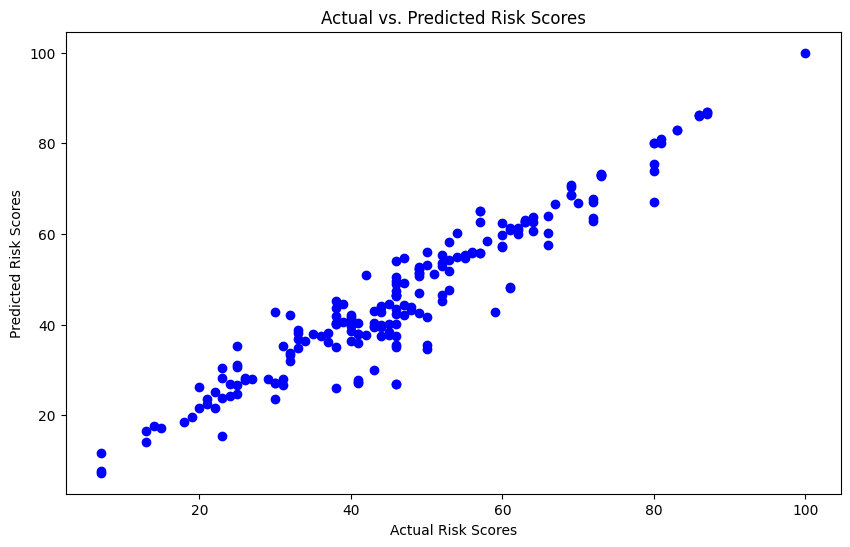

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Actual Risk Scores')
plt.ylabel('Predicted Risk Scores')
plt.title('Actual vs. Predicted Risk Scores')
plt.show()
